In [154]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [155]:
%cd gdrive/MyDrive/comptech

[Errno 2] No such file or directory: 'gdrive/MyDrive/comptech'
/content/gdrive/MyDrive/comptech


In [156]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import timedelta
from tqdm import tqdm
import warnings
import gc

import holidays

import lightgbm as lgb

from sklearn.base import BaseEstimator
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold, RandomizedSearchCV

import dill

In [157]:
tqdm.pandas()
warnings.simplefilter('ignore')

In [158]:
%pylab inline
plt.style.use('fivethirtyeight')
sns.set(rc={'figure.figsize':(16, 6)})

Populating the interactive namespace from numpy and matplotlib


In [159]:
ORDERS_PATH = 'orders.csv'
DELAYS_PATH = 'partners_delays.csv'
SEED = 2021
DATE_TEST_SPLIT = pd.to_datetime('2021-11-16')
PREV_COLS_CNT = 30
NEXT_COLS_CNT = 7
EPS = 10e-7

### Загрузка данных

In [160]:
orders = pd.read_csv(ORDERS_PATH, parse_dates=['date'])
delays = pd.read_csv(DELAYS_PATH, parse_dates=['dttm'])

In [161]:
if 0:
  orders['hour'] = orders['date'].dt.hour
  grouped_by_hour = orders.groupby('hour').mean()['orders_cnt']
  grouped_by_hour.apply(lambda x: 100 * x / float(grouped_by_hour.sum()))
  print(grouped_by_hour.to_dict())

In [162]:
orders.head()

,delivery_area_id,date,orders_cnt
0,0,2021-04-01 10:00:00,9
1,0,2021-04-01 11:00:00,1
2,0,2021-04-01 13:00:00,1
3,0,2021-04-01 14:00:00,1
4,0,2021-04-01 15:00:00,2


In [163]:
delays.head()

,delivery_area_id,dttm,partners_cnt,delay_rate
0,0,2021-04-01 09:00:00,3.0,0.000000
1,0,2021-04-01 10:00:00,4.0,0.111111
2,0,2021-04-01 11:00:00,4.0,0.000000
3,0,2021-04-01 12:00:00,4.0,0.000000
4,0,2021-04-01 13:00:00,1.0,0.000000


#### Праздничные и выходные дни

In [164]:
dayoffs = [
  '2021.01.01','2021.01.02','2021.01.03','2021.01.04','2021.01.05','2021.01.06','2021.01.07','2021.01.08','2021.01.09','2021.01.10','2021.01.16','2021.01.17','2021.01.23',
  '2021.01.24','2021.01.30','2021.01.31','2021.02.06','2021.02.07','2021.02.13','2021.02.14','2021.02.21','2021.02.22','2021.02.23','2021.02.27','2021.02.28','2021.03.06',
  '2021.03.07','2021.03.08','2021.03.13','2021.03.14','2021.03.20','2021.03.21','2021.03.27','2021.03.28','2021.04.03','2021.04.04','2021.04.10','2021.04.11','2021.04.17',
  '2021.04.18','2021.04.24','2021.04.25','2021.05.01','2021.05.02','2021.05.03','2021.05.04','2021.05.05','2021.05.06','2021.05.07','2021.05.08','2021.05.09','2021.05.10',
  '2021.05.15','2021.05.16','2021.05.22','2021.05.23','2021.05.29','2021.05.30','2021.06.05','2021.06.06','2021.06.12','2021.06.13','2021.06.14','2021.06.19','2021.06.20',
  '2021.06.26','2021.06.27','2021.07.03','2021.07.04','2021.07.10','2021.07.11','2021.07.17','2021.07.18','2021.07.24','2021.07.25','2021.07.31','2021.08.01','2021.08.07',
  '2021.08.08','2021.08.14','2021.08.15','2021.08.21','2021.08.22','2021.08.28','2021.08.29','2021.09.04','2021.09.05','2021.09.11','2021.09.12','2021.09.18','2021.09.19',
  '2021.09.25','2021.09.26','2021.10.02','2021.10.03','2021.10.09','2021.10.10','2021.10.16','2021.10.17','2021.10.23','2021.10.24','2021.10.30','2021.10.31','2021.11.01',
  '2021.11.02','2021.11.03','2021.11.04','2021.11.05','2021.11.06','2021.11.07','2021.11.13','2021.11.14','2021.11.20','2021.11.21','2021.11.27','2021.11.28','2021.12.04',
  '2021.12.05','2021.12.11','2021.12.12','2021.12.18','2021.12.19','2021.12.25','2021.12.26','2021.12.31'
]
dayoffs = [pd.to_datetime(day) for day in dayoffs]

In [165]:
holidays_dict = holidays.RU(years=(2021))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index').reset_index()
df_holidays.columns = ['ds', 'holiday']
df_holidays['ds'] = pd.to_datetime(df_holidays['ds'])
df_holidays.head()

,ds,holiday
0,2021-01-01,Новый год
1,2021-01-02,Новый год
2,2021-01-03,Новый год
3,2021-01-04,Новый год
4,2021-01-05,Новый год


#### Описательные статистики

In [166]:
delays.describe()

,delivery_area_id,partners_cnt,delay_rate
count,1.247471e+06,1.247471e+06,1.247471e+06
mean,2.698000e+02,2.026328e+00,2.831878e-02
std,1.765557e+02,1.671793e+00,1.009584e-01
min,0.000000e+00,1.000000e+00,0.000000e+00
25%,1.050000e+02,1.000000e+00,0.000000e+00
50%,2.650000e+02,1.000000e+00,0.000000e+00
75%,4.210000e+02,2.000000e+00,0.000000e+00
max,5.920000e+02,6.000000e+01,1.000000e+00


In [167]:
orders.describe()

,delivery_area_id,orders_cnt
count,884856.000000,884856.000000
mean,259.623341,3.790038
std,178.580787,3.808991
min,0.000000,1.000000
25%,88.000000,1.000000
50%,253.000000,3.000000
75%,416.000000,5.000000
max,592.000000,120.000000


#### Разбиение даты на составляющие

In [168]:
def split_date_time(data):
  data['dttm'] = pd.to_datetime(data['dttm'])
  data['year'] = data['dttm'].dt.year
  data['month'] = data['dttm'].dt.month
  data['week'] = data['dttm'].dt.week
  data['dayofweek'] = data['dttm'].dt.dayofweek
  data['doy'] = data['dttm'].dt.dayofyear
  #data['time'] = data['dttm'].dt.time
  #data['hour'] = data['dttm'].dt.hour
  #data['hour_cos'] = np.cos(2 * math.pi * data['hour'] / 24)
  #data['hour_sin'] = np.sin(2 * math.pi * data['hour'] / 24)
  return data

#### Группировка по дате

In [169]:
orders['date'] = orders['date'].dt.date
orders = orders.groupby(['delivery_area_id', 'date']).sum()['orders_cnt'].reset_index()

In [170]:
orders['dttm'] = orders['date']
delays = split_date_time(delays)
orders = split_date_time(orders)

#### Добавление 0 для отсутствующих значений

In [171]:
if 0:
  dates = pd.date_range(orders.date.min(), orders.date.max() + timedelta(days=1), freq='H').tolist()
  dates = [date for date in dates if date.hour > 9 and date.hour < 20]

In [172]:
if 0:
  dict_list = []
  for delivery_area in tqdm(orders['delivery_area_id'].unique(), position=0, leave=True):
    for date in dates:
        dict_list.append({
          'delivery_area_id': delivery_area,
          'date': date,
          'orders_cnt': 0
        })

  zeros_df = pd.DataFrame(dict_list)
  print(zeros_df.shape)
  zeros_df.head()

In [173]:
if 0:
  intersection = pd.merge(zeros_df.reset_index(), orders, how='inner', on=['date', 'delivery_area_id'])['index']
  distinction = zeros_df.drop(zeros_df.iloc[intersection.values].index)
  assert distinction.shape[0] == zeros_df.shape[0] - intersection.shape[0]

In [174]:
if 0:
  orders = pd.concat([orders, distinction], ignore_index=True)
  orders = orders.sort_values(by=['delivery_area_id', 'date'])
  orders

### Визуализации

#### Среднее опоздание по дням

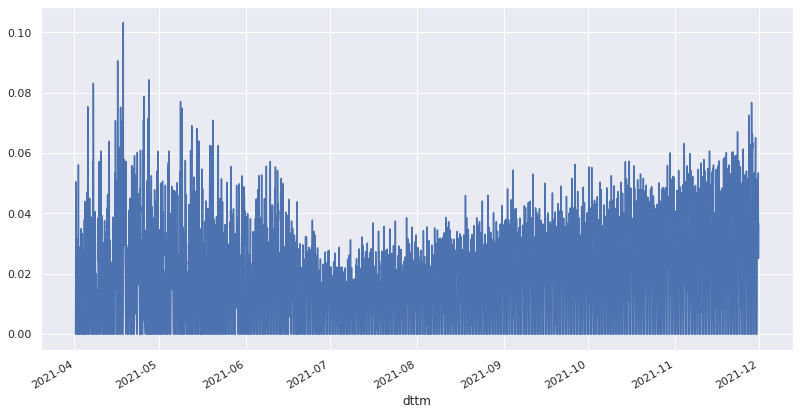

In [175]:
delays.groupby('dttm').mean()['delay_rate'].plot(figsize=(12, 7), grid=True)

#### Среднее опоздание по времени дня

In [176]:
#delays.groupby('hour').mean()['delay_rate'].plot(figsize=(12, 7), grid=True)

#### Количество заказов по дням

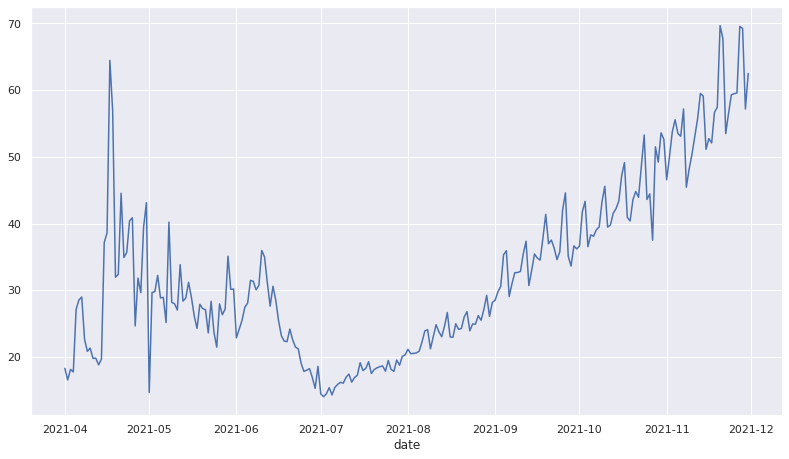

In [177]:
orders.groupby('date').mean()['orders_cnt'].plot(figsize=(12, 7), grid=True)

#### Количество заказов по времени дня

In [178]:
#orders.groupby('hour').mean()['orders_cnt'].plot(figsize=(12, 7), grid=True)

#### orders_cnt для разных delivery_area_id

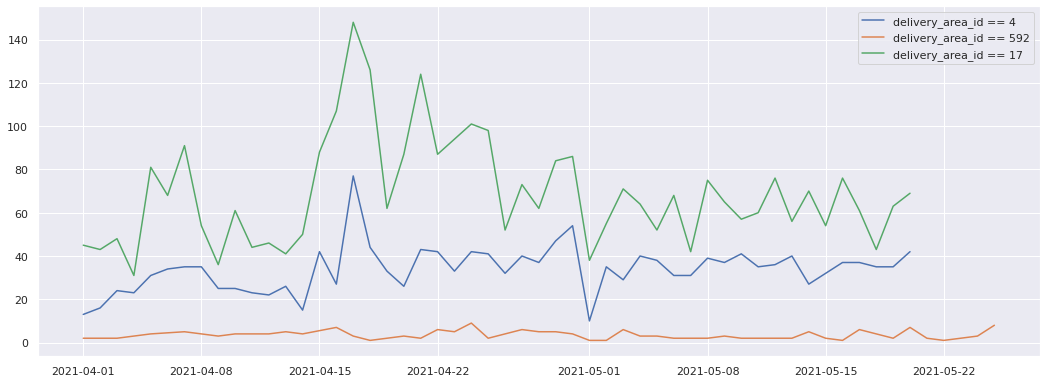

In [179]:
for delivery_area in [4, 592, 17]:
  plt.plot(
      orders[orders['delivery_area_id'] == delivery_area]['date'][:50],
      orders[orders['delivery_area_id'] == delivery_area]['orders_cnt'][:50],
      label=f'delivery_area_id == {delivery_area}'
  )
plt.legend()

### Utils

In [180]:
def get_test_data(X):
  X_train = X[X['date'] <= DATE_TEST_SPLIT]
  X_test = X[X['date'] > DATE_TEST_SPLIT]
  return X_train, X_test

In [181]:
def timeseries_train_test_split(X, y=None, test_size=0.3):
  X = X.sort_values(by='date')
  test_index = int(len(X) * (1 - test_size))
  X_train = X.iloc[:test_index]
  X_test = X.iloc[test_index:]
  if y is not None:
    y_train = y.iloc[:test_index]
    y_test = y.iloc[test_index:]
    return X_train, X_test, y_train, y_test
  return X_train, X_test

In [182]:
def save_all_dfs(X_train, X_val, X_test, name_suffix):
  X_train.to_csv(f'X_train_{name_suffix}.csv', index=False)
  X_val.to_csv(f'X_val_{name_suffix}.csv', index=False)
  X_test.to_csv(f'X_test_{name_suffix}.csv', index=False)
  print('Данные сохранены')

In [183]:
def load_all(name_suffix):
  X_train = pd.read_csv(f'X_train_{name_suffix}.csv')
  X_val = pd.read_csv(f'X_val_{name_suffix}.csv')
  X_test = pd.read_csv(f'X_test_{name_suffix}.csv')
  return X_train, X_val, X_test

### Подготовка данных

#### Генерация признаков вида i дней назад/вперед

In [184]:
def get_prev_next_features(data):
  data = data.sort_values(by=['delivery_area_id', 'date'])

  for i in range(1, PREV_COLS_CNT + 1):
    data['prev_' + str(i)] = data.groupby(['delivery_area_id', 'date'], as_index=False).mean().shift(i).rolling(1).sum()['orders_cnt']

  data["future_1"] = data['orders_cnt'].copy()
  for i in range(2, NEXT_COLS_CNT + 1):
    data["future_" + str(i)] = data.groupby(['delivery_area_id', 'date'], as_index=False).mean().shift(-i+1).rolling(1).mean()['orders_cnt']

  return data

In [185]:
orders = get_prev_next_features(orders)

#### Train/val/test split

In [186]:
X_train, X_test = get_test_data(orders)
X_train, X_val = timeseries_train_test_split(X_train, test_size=0.2)

print(f'Train shape: {X_train.shape}')
print(f'Valid shape: {X_val.shape}')
print(f'Test shape: {X_test.shape}')

Train shape: (71230, 46)
Valid shape: (17808, 46)
Test shape: (8168, 46)


In [187]:
del orders
gc.collect()

125

#### Праздники и нерабочие дни

In [188]:
def get_holidays_features(data):
  data['is_holiday'] = data.progress_apply(lambda x: x['date'] in df_holidays['ds'].values, axis=1)
  data['is_dayoff'] = data.progress_apply(lambda x: x['date'] in dayoffs, axis=1)
  data['is_weekend'] = data.progress_apply(lambda x: x['dayofweek'] in [5, 6], axis=1)
  return data

In [189]:
X_train = get_holidays_features(X_train)
X_val = get_holidays_features(X_val)
X_test = get_holidays_features(X_test)

X_train.head()

100%|██████████| 8168/8168 [00:00<00:00, 23256.99it/s]


,delivery_area_id,date,orders_cnt,dttm,year,month,week,dayofweek,doy,prev_1,prev_2,prev_3,prev_4,prev_5,prev_6,prev_7,prev_8,prev_9,prev_10,prev_11,prev_12,prev_13,prev_14,prev_15,prev_16,prev_17,prev_18,prev_19,prev_20,prev_21,prev_22,prev_23,prev_24,prev_25,prev_26,prev_27,prev_28,prev_29,prev_30,future_1,future_2,future_3,future_4,future_5,future_6,future_7,is_holiday,is_dayoff,is_weekend
0,0,2021-04-01,24,2021-04-01,2021,4,13,3,91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24,21.0,33.0,18.0,32.0,29.0,36.0,False,False,False
5383,23,2021-04-01,18,2021-04-01,2021,4,13,3,91,86.0,71.0,104.0,85.0,70.0,60.0,75.0,78.0,67.0,85.0,91.0,67.0,84.0,69.0,72.0,75.0,53.0,77.0,90.0,73.0,65.0,57.0,71.0,104.0,85.0,92.0,76.0,101.0,80.0,67.0,18,22.0,22.0,12.0,33.0,34.0,34.0,False,False,False
747,4,2021-04-01,13,2021-04-01,2021,4,13,3,91,93.0,84.0,128.0,113.0,87.0,83.0,79.0,77.0,78.0,98.0,103.0,84.0,96.0,113.0,92.0,86.0,94.0,99.0,95.0,78.0,73.0,75.0,78.0,90.0,85.0,103.0,105.0,88.0,91.0,75.0,13,16.0,24.0,23.0,31.0,34.0,35.0,False,False,False
12413,52,2021-04-01,2,2021-04-01,2021,4,13,3,91,266.0,220.0,239.0,249.0,202.0,223.0,191.0,195.0,164.0,239.0,258.0,209.0,188.0,195.0,194.0,166.0,196.0,200.0,199.0,177.0,147.0,156.0,159.0,195.0,188.0,192.0,194.0,209.0,185.0,135.0,2,2.0,4.0,5.0,2.0,1.0,4.0,False,False,False
5627,24,2021-04-01,35,2021-04-01,2021,4,13,3,91,233.0,192.0,218.0,231.0,200.0,209.0,201.0,176.0,197.0,262.0,256.0,179.0,193.0,215.0,178.0,186.0,220.0,226.0,200.0,202.0,184.0,179.0,156.0,236.0,206.0,174.0,202.0,207.0,202.0,164.0,35,20.0,25.0,30.0,49.0,56.0,48.0,False,False,False


#### Сколько дней до ближайших праздников / Сколько дней от последнего праздника

In [190]:
celebrations = pd.DataFrame(
    ['2021-01-01', '2021-02-23', '2021-02-14', '2021-03-08', '2021-09-01', '2021-12-31'],
    columns=['date']
)
celebrations['date'] = pd.to_datetime(celebrations['date'])
celebrations['doy'] = celebrations['date'].dt.dayofyear    

df_holidays['doy'] = df_holidays['ds'].dt.dayofyear   

In [191]:
def get_days_before_nearest_day(row, calendar=df_holidays):
  current_doy = row['doy']
  days_after_current = calendar[calendar['doy'] >= current_doy]['doy']
  if len(days_after_current) > 0:
    days = min(days_after_current) - current_doy
    return days
  else:
    return 0

def get_days_after_nearest_day(row, calendar=df_holidays):
  current_doy = row['doy']
  days = abs(max(calendar[calendar['doy'] <= current_doy]['doy']) - current_doy)
  return days

def get_days_to_holidays(data):
  data['days_before_of_holiday'] = data.apply(lambda x: get_days_before_nearest_day(x), axis=1)
  data['days_before_celebrations'] = data.apply(lambda x: get_days_before_nearest_day(x, celebrations), axis=1)
  data['days_after_of_holiday'] = data.apply(lambda x: get_days_after_nearest_day(x), axis=1)
  data['days_after_celebrations'] = data.apply(lambda x: get_days_after_nearest_day(x, celebrations), axis=1)
  return data

In [192]:
%time
X_train = get_days_to_holidays(X_train)
X_val = get_days_to_holidays(X_val)
X_test = get_days_to_holidays(X_test)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs


#### Нормировка на медиану

In [193]:
prev_cols = ["prev_" + str(i) for i in range(1, PREV_COLS_CNT + 1)][:7]  
X_train['1_week_median_all'] = X_train[prev_cols].median(1)
X_val['1_week_median_all'] = X_val[prev_cols].median(1)
X_test['1_week_median_all'] = X_test[prev_cols].median(1)

In [194]:
def norm_by_1_week_median(data):
  cols_to_norm = ["prev_" + str(i) for i in range(1, PREV_COLS_CNT + 1)] + ["future_" + str(i) for i in range(1, NEXT_COLS_CNT + 1)]
  for col in cols_to_norm:
    data[col] = data[col] / (data['1_week_median_all'] + EPS)
  return data

In [195]:
X_train = norm_by_1_week_median(X_train)
X_val = norm_by_1_week_median(X_val)
X_test = norm_by_1_week_median(X_test)

In [196]:
save_all_dfs(X_train, X_val, X_test, name_suffix='base_normalized')

Данные сохранены


#### Статистики

In [197]:
def get_aggregations(data, period, cols_range_left, cols_range_right):
  prev_cols = ["prev_" + str(i) for i in range(1, PREV_COLS_CNT + 1)][cols_range_left:cols_range_right]  

  data[f'{period}_median'] = data[prev_cols].median(1)
  data[f'{period}_mean'] = data[prev_cols].mean(1)
  data[f'{period}_std'] = data[prev_cols].std(1)
  data[f'{period}_min'] = data[prev_cols].min(1)
  data[f'{period}_max'] = data[prev_cols].max(1)    
  data[f'{period}_sum'] = data[prev_cols].sum(1)
  return data

In [198]:
def get_stat_changes(data, first_period='1_week', last_period='2_week'):
  for stat in ['median', 'mean', 'std', 'min', 'max', 'sum']:
    data[f'week_{stat}_change'] = (data[f'{first_period}_{stat}'] - data[f'{last_period}_{stat}']) / (data[f'{last_period}_{stat}'] + EPS)
  return data

In [199]:
X_train, X_val, X_test = load_all(name_suffix='base_normalized')

In [200]:
def get_statistics(data):
  data = get_aggregations(data, '1_week', cols_range_left=0, cols_range_right=7)
  data = get_aggregations(data, '2_week', cols_range_left=7, cols_range_right=14)
  data = get_aggregations(data, '1_month', cols_range_left=0, cols_range_right=30)

  data = get_stat_changes(data)
  return data

In [201]:
X_train = get_statistics(X_train)
X_val = get_statistics(X_val)
X_test = get_statistics(X_test)

In [202]:
X_train.shape

(71230, 78)

#### Кластеризация рядов

### LightGBM

#### Инициализация

In [203]:
params = {
    'metric' : 'mape',
    'objective': 'mape',
    'learning_rate': 0.1,
    'seed': SEED,
    'max_depth': 10,
    'verbose' : -1
}

In [204]:
class LGBMWeekModel(BaseEstimator):
    def __init__(self, params):
      self.params = params
      self.models = []
    
    def fit(self, data):
      for i in tqdm(range(7)):
        train_data = data.dropna(subset=[f'future_{i + 1}'])
        train_data = train_data.drop(train_data[train_data[f'future_{i + 1}'] == 0].index)
        train_data = lgb.Dataset(
            train_data.drop([f'future_{i}' for i in range(1, NEXT_COLS_CNT + 1)], axis=1),
            label=train_data[f'future_{i + 1}']
        )

        model = lgb.train(
          params=self.params,
          train_set=train_data,
          valid_sets=[train_data],
          num_boost_round=100, 
          verbose_eval=1000
        )
        self.models.append(model)
      return self
    
    def predict(self, data):
      preds_df = pd.DataFrame()
      for i in range(7):
        preds_df['pred_' + str(i)] = self.models[i].predict(data)
      return preds_df

In [205]:
model = LGBMWeekModel(params)
model.fit(X_train.drop(['date', 'dttm', 'orders_cnt'], axis=1))

100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


LGBMWeekModel(params={'learning_rate': 0.1, 'max_depth': 10, 'metric': 'mape',
                      'objective': 'mape', 'seed': 2021, 'verbose': -1})

In [206]:
res = model.predict(X_val.drop(['date', 'dttm', 'orders_cnt'], axis=1))

In [207]:
for i in range(7):
  print(mean_absolute_percentage_error(X_val[f'future_{i + 1}'], res['pred_' + str(i)]))

0.21324335869522973
0.22270786331787404
0.2404739231616467
0.24426753283646996
0.27984808956768525
0.2434812573596059
0.28980283734112344


In [208]:
X_test = X_test.dropna()

In [209]:
res = model.predict(X_test.drop(['date', 'dttm', 'orders_cnt'], axis=1))
for i in range(7):
  print(mean_absolute_percentage_error(X_test[f'future_{i + 1}'] * X_test['1_week_median_all'].values, res['pred_' + str(i)] * X_test['1_week_median_all'].values))

0.180991167899655
1.6119304065790319
3.04636417313962
4.268160647448766
6.075992156278799
6.5978001808034925
8.606760169898664


#### Подбор гиперпараметров

In [213]:
params_grid = {
    'learning_rate': [0.1, 0.3, 0.01],
    'max_depth': [i for i in range(5, 13)],
    'num_leaves': [25, 30, 32], # max number of leaves in one tree
    'min_child_samples': [10, 15, 20], # minimal number of data in one leaf
    'reg_alpha': [0.0, 0.1],
    'reg_lambda': [0.0, 0.1],
    'metric' : ['mape'],
    'objective': ['mape'],
    'seed': [SEED],
}

In [214]:
%%time

if 1:
  kfcv = KFold(n_splits=3)
  opt_params = []

  for i in tqdm(range(7)):
    train_data = X_train.drop(['date', 'dttm'], axis=1)
    train_data = train_data.dropna(subset=[f'future_{i + 1}'])
    train_data = train_data.drop(train_data[train_data[f'future_{i + 1}'] == 0].index)

    model = lgb.LGBMRegressor(
      random_state=SEED,
      num_boost_round=100, 
      verbose=-1,
      metric='mape',
      objective='mape',
    )
    
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=params_grid,
        scoring='neg_mean_absolute_percentage_error',
        cv=kfcv,
        verbose=1,
        random_state=SEED,
        return_train_score=True,
        n_iter=20
    )

    search.fit(
        train_data.drop([f'future_{i}' for i in range(1, NEXT_COLS_CNT + 1)], axis=1),
        train_data[f'future_{i + 1}']
    )

    print(f'{i}: {search.best_score_}')
    opt_params.append(search.best_params_)

  0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 20 candidates, totalling 60 fits


 14%|█▍        | 1/7 [04:44<28:27, 284.59s/it]

0: -0.040059216765336685
Fitting 3 folds for each of 20 candidates, totalling 60 fits


 29%|██▊       | 2/7 [09:14<22:58, 275.79s/it]

1: -0.3957415779310687
Fitting 3 folds for each of 20 candidates, totalling 60 fits


 43%|████▎     | 3/7 [13:58<18:38, 279.63s/it]

2: -0.4060382182562741
Fitting 3 folds for each of 20 candidates, totalling 60 fits


 57%|█████▋    | 4/7 [18:27<13:46, 275.53s/it]

3: -0.4242575527347265
Fitting 3 folds for each of 20 candidates, totalling 60 fits


 71%|███████▏  | 5/7 [22:57<09:06, 273.40s/it]

4: -0.4134512114165894
Fitting 3 folds for each of 20 candidates, totalling 60 fits


 86%|████████▌ | 6/7 [27:25<04:31, 271.75s/it]

5: -0.40911509346591796
Fitting 3 folds for each of 20 candidates, totalling 60 fits


100%|██████████| 7/7 [31:53<00:00, 273.29s/it]

6: -0.40909072985338907
CPU times: user 58min 19s, sys: 15.7 s, total: 58min 35s
Wall time: 31min 53s


In [215]:
opt_params

[{'learning_rate': 0.3,
  'max_depth': 10,
  'metric': 'mape',
  'min_child_samples': 15,
  'num_leaves': 25,
  'objective': 'mape',
  'reg_alpha': 0.1,
  'reg_lambda': 0.0,
  'seed': 2021},
 {'learning_rate': 0.1,
  'max_depth': 9,
  'metric': 'mape',
  'min_child_samples': 20,
  'num_leaves': 32,
  'objective': 'mape',
  'reg_alpha': 0.1,
  'reg_lambda': 0.1,
  'seed': 2021},
 {'learning_rate': 0.1,
  'max_depth': 12,
  'metric': 'mape',
  'min_child_samples': 10,
  'num_leaves': 32,
  'objective': 'mape',
  'reg_alpha': 0.0,
  'reg_lambda': 0.0,
  'seed': 2021},
 {'learning_rate': 0.3,
  'max_depth': 5,
  'metric': 'mape',
  'min_child_samples': 20,
  'num_leaves': 30,
  'objective': 'mape',
  'reg_alpha': 0.1,
  'reg_lambda': 0.1,
  'seed': 2021},
 {'learning_rate': 0.3,
  'max_depth': 9,
  'metric': 'mape',
  'min_child_samples': 15,
  'num_leaves': 30,
  'objective': 'mape',
  'reg_alpha': 0.0,
  'reg_lambda': 0.0,
  'seed': 2021},
 {'learning_rate': 0.3,
  'max_depth': 5,
  'met

In [ ]:
opt_params = [{'learning_rate': 0.3,
  'max_depth': 10,
  'metric': 'mape',
  'min_child_samples': 15,
  'num_leaves': 25,
  'objective': 'mape',
  'reg_alpha': 0.1,
  'reg_lambda': 0.0,
  'seed': 2021},
 {'learning_rate': 0.1,
  'max_depth': 9,
  'metric': 'mape',
  'min_child_samples': 20,
  'num_leaves': 32,
  'objective': 'mape',
  'reg_alpha': 0.1,
  'reg_lambda': 0.1,
  'seed': 2021},
 {'learning_rate': 0.1,
  'max_depth': 12,
  'metric': 'mape',
  'min_child_samples': 10,
  'num_leaves': 32,
  'objective': 'mape',
  'reg_alpha': 0.0,
  'reg_lambda': 0.0,
  'seed': 2021},
 {'learning_rate': 0.3,
  'max_depth': 5,
  'metric': 'mape',
  'min_child_samples': 20,
  'num_leaves': 30,
  'objective': 'mape',
  'reg_alpha': 0.1,
  'reg_lambda': 0.1,
  'seed': 2021},
 {'learning_rate': 0.3,
  'max_depth': 9,
  'metric': 'mape',
  'min_child_samples': 15,
  'num_leaves': 30,
  'objective': 'mape',
  'reg_alpha': 0.0,
  'reg_lambda': 0.0,
  'seed': 2021},
 {'learning_rate': 0.3,
  'max_depth': 5,
  'metric': 'mape',
  'min_child_samples': 15,
  'num_leaves': 25,
  'objective': 'mape',
  'reg_alpha': 0.1,
  'reg_lambda': 0.0,
  'seed': 2021},
 {'learning_rate': 0.1,
  'max_depth': 12,
  'metric': 'mape',
  'min_child_samples': 10,
  'num_leaves': 32,
  'objective': 'mape',
  'reg_alpha': 0.0,
  'reg_lambda': 0.0,
  'seed': 2021}]

In [220]:
class LGBMWeekModel(BaseEstimator):
    def __init__(self, params_list):
      self.params = params_list
      self.models = []
    
    def fit(self, data):
      for i in tqdm(range(7)):
        params = self.params[i]
        train_data = data.dropna(subset=[f'future_{i + 1}'])
        train_data = train_data.drop(train_data[train_data[f'future_{i + 1}'] == 0].index)
        train_data = lgb.Dataset(
            train_data.drop([f'future_{i}' for i in range(1, NEXT_COLS_CNT + 1)], axis=1),
            label=train_data[f'future_{i + 1}']
        )
        model = lgb.train(
          params=self.params[i],
          train_set=train_data,
          valid_sets=[train_data],
          num_boost_round=100, 
          verbose_eval=1000
        )
        self.models.append(model)
    
    def predict(self, data):
      preds_df = pd.DataFrame()
      for i in range(7):
        preds_df['pred_' + str(i)] = self.models[i].predict(data)
      return preds_df

In [221]:
model = LGBMWeekModel(opt_params)
model.fit(X_train.drop(['date', 'dttm', 'orders_cnt'], axis=1))

100%|██████████| 7/7 [00:38<00:00,  5.45s/it]


In [222]:
res = model.predict(X_val.drop(['date', 'dttm', 'orders_cnt'], axis=1))
for i in range(7):
  print(mean_absolute_percentage_error(X_val[f'future_{i + 1}'] * X_val['1_week_median_all'].values, res['pred_' + str(i)] * X_val['1_week_median_all'].values))

0.22909472651409815
0.22326215324559504
0.23604876743074363
0.28105377175953916
0.30384655121634396
0.2635783601261714
0.2753009589965935


In [223]:
res = model.predict(X_test.drop(['date', 'dttm', 'orders_cnt'], axis=1))
for i in range(7):
  print(mean_absolute_percentage_error(X_test[f'future_{i + 1}'] * X_test['1_week_median_all'].values, res['pred_' + str(i)] * X_test['1_week_median_all'].values))

0.2007767042496252
1.629975691518154
2.9404200050956684
4.531656597481989
6.228618071416735
7.087811806955421
8.385109560546445


#### Отбор признаков

##### Топ-20 признаков для каждой из моделей


In [224]:
f_importances_list = []

for m in model.models:
  f_importances = pd.DataFrame(
      {
        'cols': X_train.drop(['date', 'dttm', 'orders_cnt'] + [f'future_{i}' for i in range(1, NEXT_COLS_CNT + 1)], axis=1).columns,
        'importance': m.feature_importance()
      }
  )
  f_importances.loc[f_importances['importance'] > 0].sort_values(by=['importance'], ascending = False)
  f_importances_list.append(f_importances)

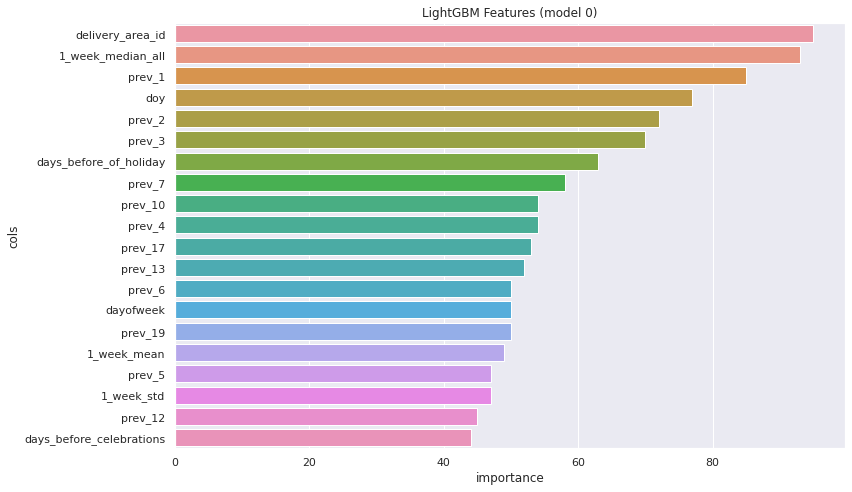

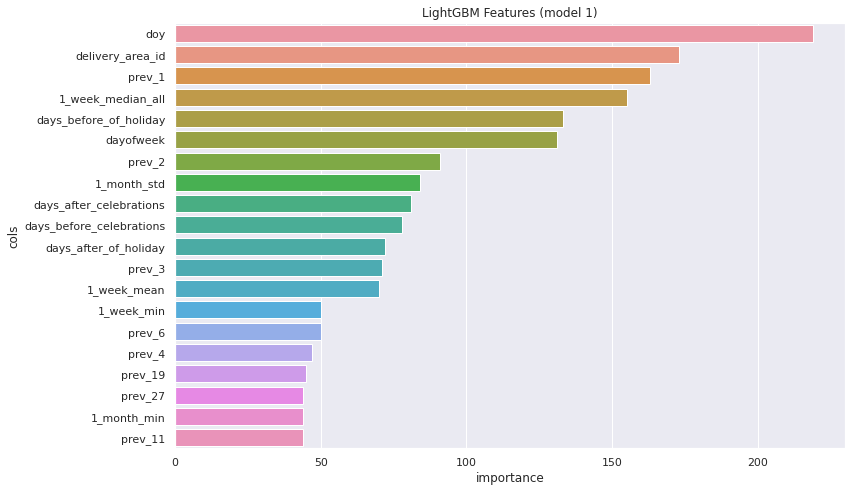

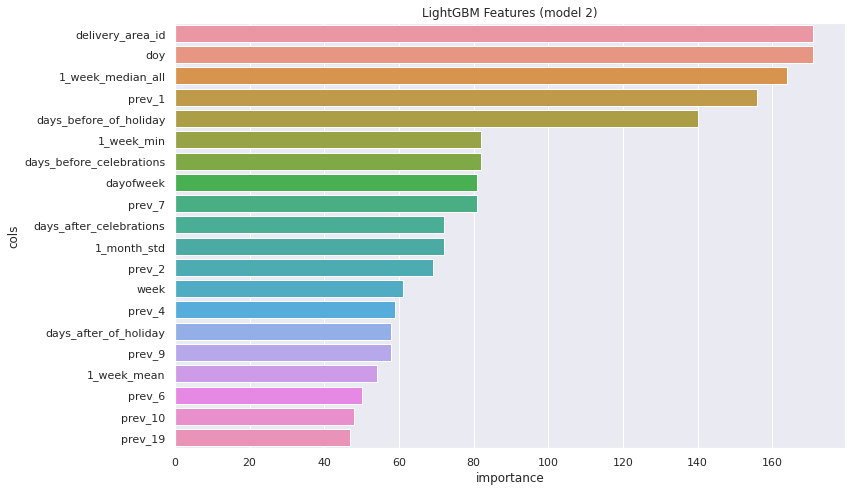

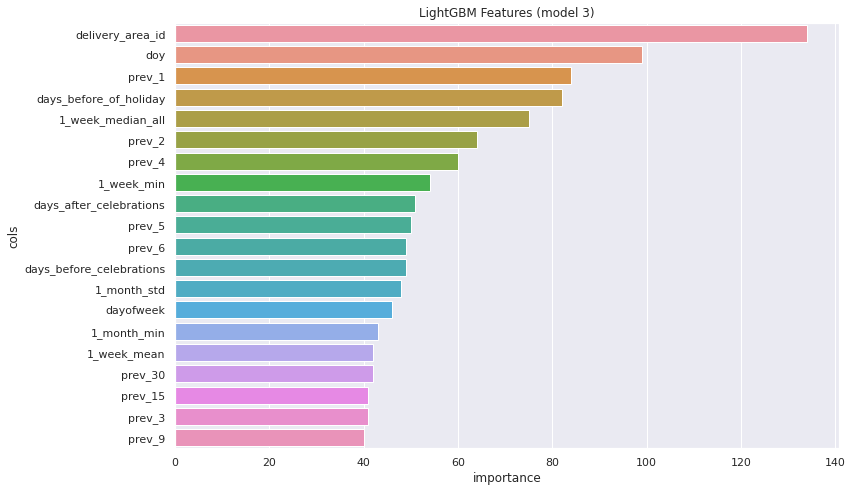

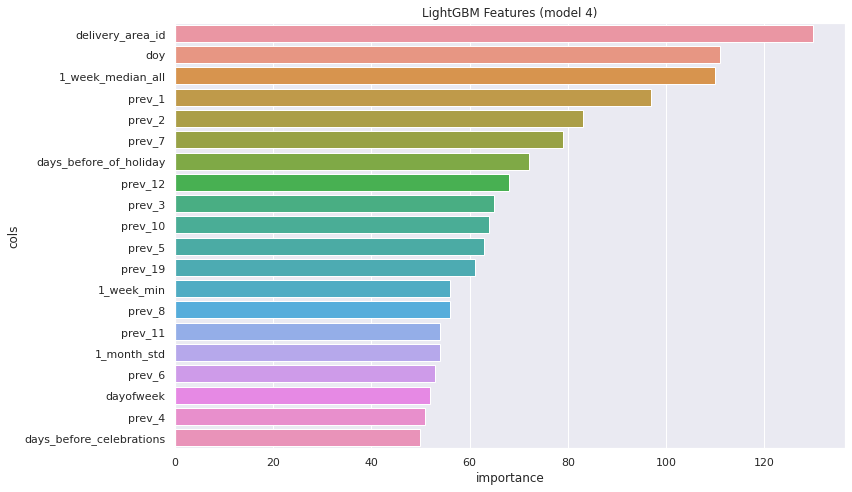

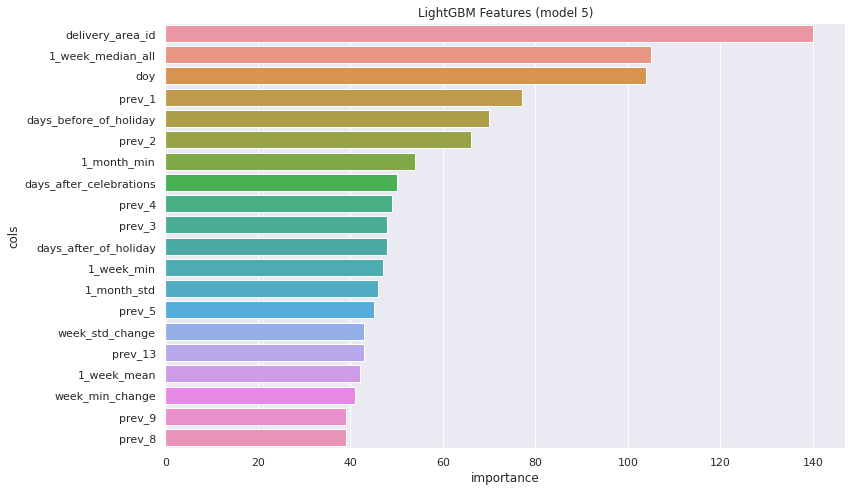

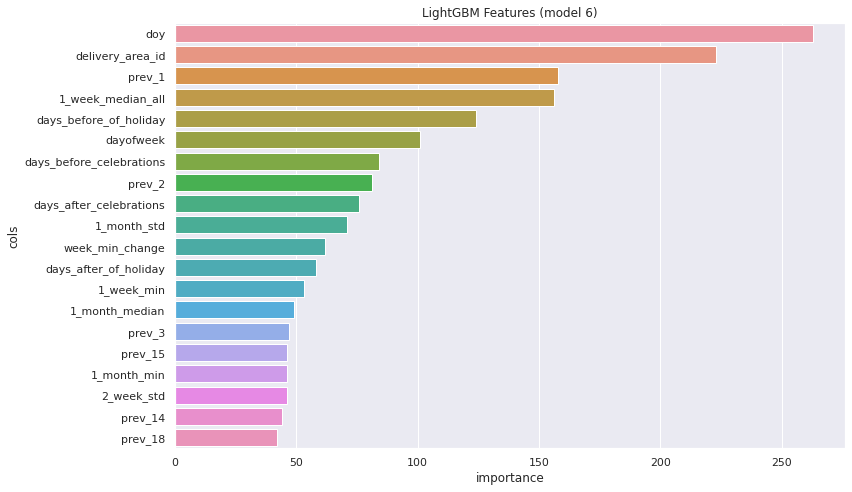

In [225]:
for i, fi in enumerate(f_importances_list):
  plt.figure(figsize=(12, 7))
  sns.barplot(
      x="importance",
      y="cols",
      data=f_importances_list[i].sort_values(by="importance", ascending=False)[0:20]
  )
  plt.title(f'LightGBM Features (model {i})')
  plt.tight_layout()
  plt.show()

##### Переобучение на топ-признаках

In [226]:
class LGBMWeekModelTopFeatures(BaseEstimator):
    def __init__(self):
      self.models = []
    
    def fit(self, data, params_list, f_importances):
      self.f_importances = f_importances
      for i in tqdm(range(7)):
        params = params_list[i]
        train_data = data.dropna(subset=[f'future_{i + 1}'])
        train_data = train_data.drop(train_data[train_data[f'future_{i + 1}'] == 0].index)
        need_columns = self.f_importances[i].sort_values(by="importance", ascending=False)[0:30]['cols'].values
        train_data = lgb.Dataset(
            train_data[need_columns],
            label=train_data[f'future_{i + 1}']
        )
        model = lgb.train(
          params=params,
          train_set=train_data,
          valid_sets=[train_data],
          num_boost_round=100, 
          verbose_eval=1000
        )
        self.models.append(model)
      return self
    
    def predict(self, data):
      preds_df = pd.DataFrame()
      for i in range(7):
        need_columns = self.f_importances[i].sort_values(by="importance", ascending=False)[0:30]['cols'].values
        preds_df['pred_' + str(i)] = self.models[i].predict(data[need_columns])
      return preds_df

In [227]:
model = LGBMWeekModelTopFeatures()
model.fit(X_train.drop(['date', 'dttm', 'orders_cnt'], axis=1), opt_params, f_importances_list)

100%|██████████| 7/7 [00:22<00:00,  3.21s/it]


LGBMWeekModelTopFeatures()

In [228]:
res = model.predict(X_val.drop(['date', 'dttm', 'orders_cnt'], axis=1))
for i in range(7):
  print(mean_absolute_percentage_error(X_val[f'future_{i + 1}'] * X_val['1_week_median_all'].values, res['pred_' + str(i)] * X_val['1_week_median_all'].values))

0.22404510239682524
0.2302678369571995
0.22272236574524212
0.30175484262232677
0.25409192811334
0.283292385585661
0.2501394357668218


In [229]:
res = model.predict(X_test.drop(['date', 'dttm', 'orders_cnt'], axis=1))
for i in range(7):
  print(mean_absolute_percentage_error(X_test[f'future_{i + 1}'] * X_test['1_week_median_all'].values, res['pred_' + str(i)] * X_test['1_week_median_all'].values))

0.21598759179047003
1.559927100923124
2.9140743201492474
4.082172602708473
4.9717981172517405
5.929284429134933
7.234763396775335


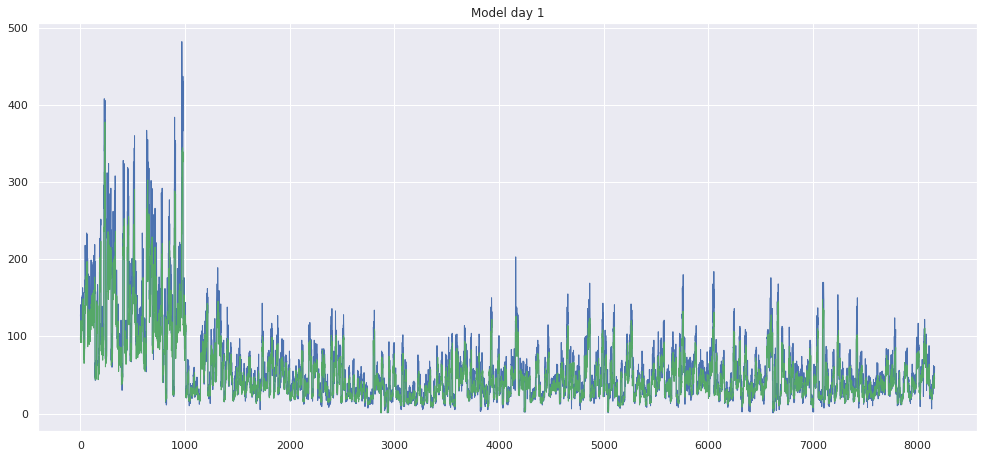

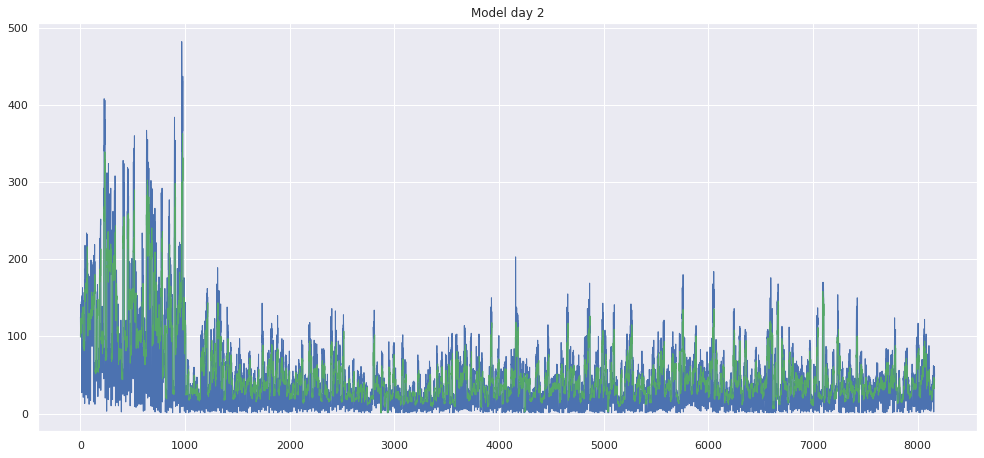

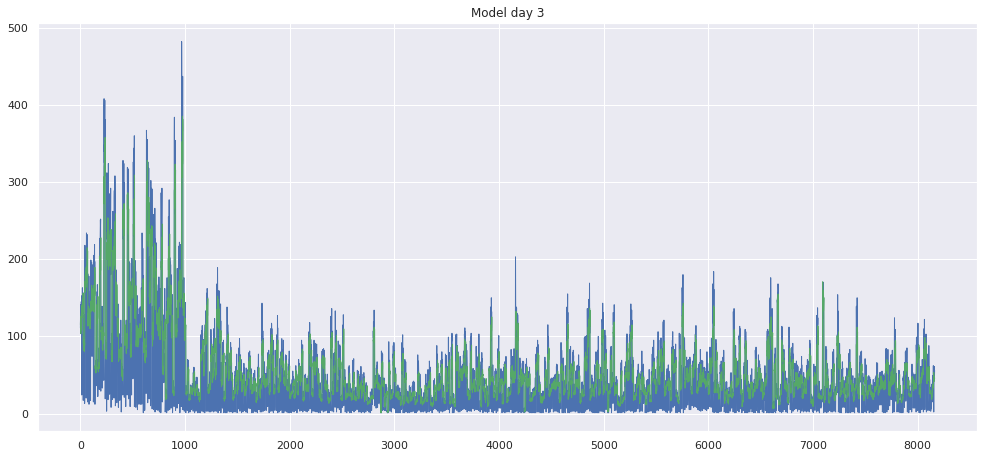

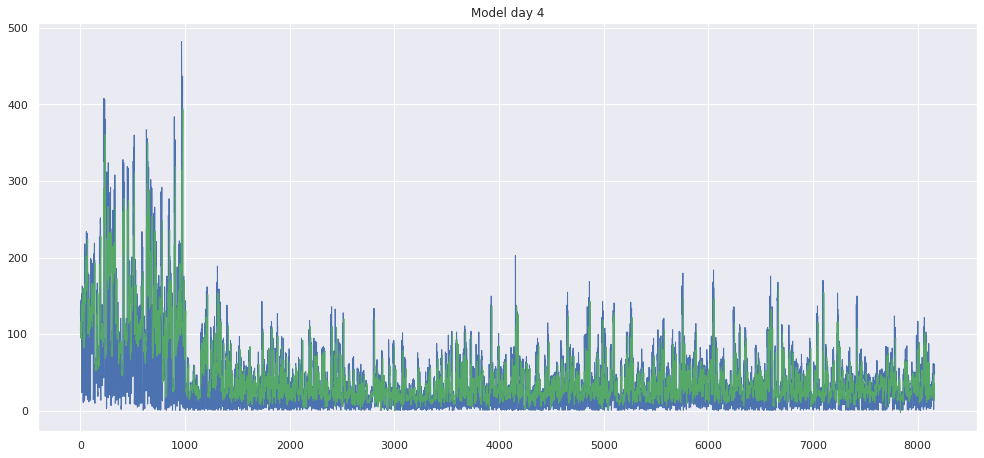

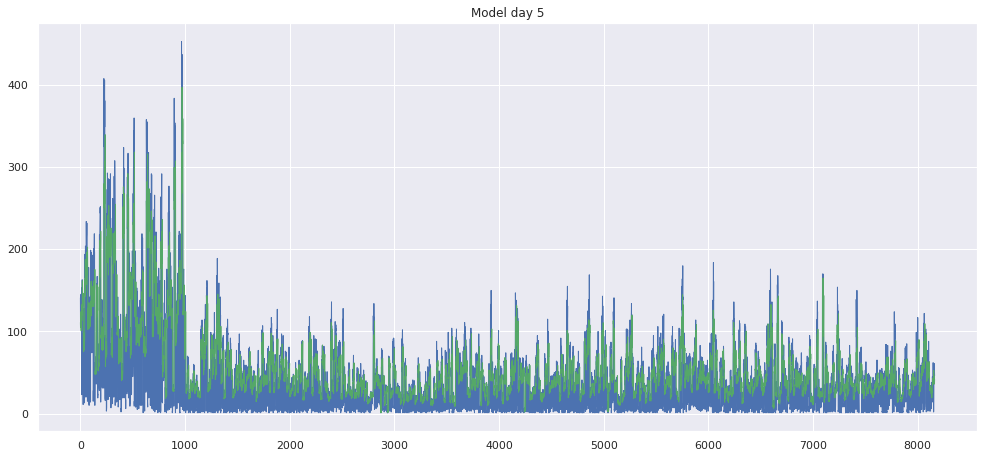

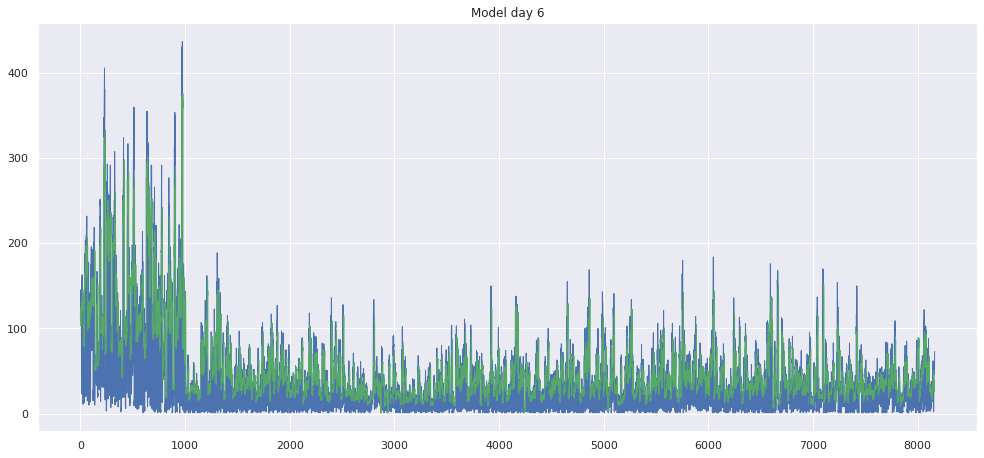

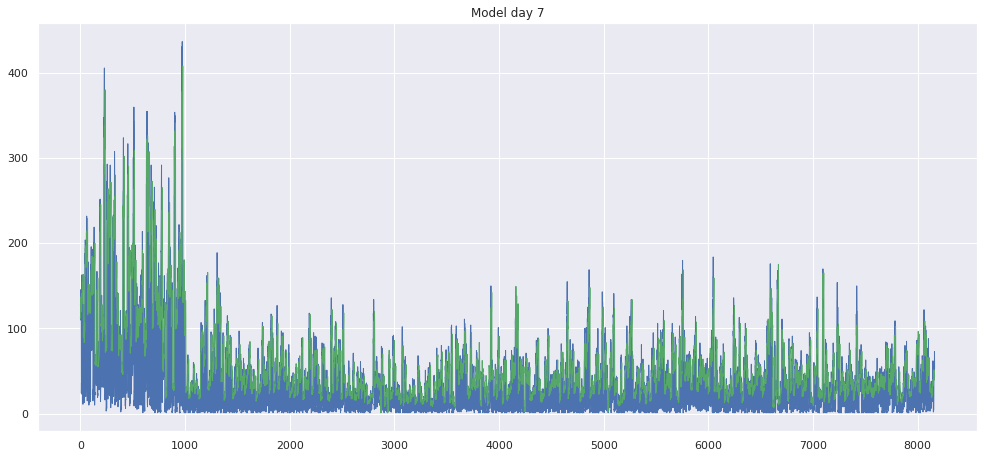

In [232]:
for i in range(7):
  plt.figure(figsize=(15, 7))
  plt.plot((X_test[f'future_{i + 1}']).values * X_test['1_week_median_all'].values, label="actual", linewidth=1.0)
  plt.plot((res['pred_' + str(i)]).values * X_test['1_week_median_all'].values, "g", label="prediction", linewidth=1.0)
  plt.title(f'Model day {i + 1}')
  

#### Сохранение обученной модели

In [233]:
import pickle

In [234]:
with open("lgbm_model_1.pkl", "wb") as f:
    pickle.dump(model, f)

In [235]:
with open("lgbm_model_1.pkl", "rb") as f:
    model = pickle.load(f)
model

LGBMWeekModelTopFeatures()

In [236]:
res = model.predict(X_test.drop(['date', 'dttm', 'orders_cnt'], axis=1))
for i in range(7):
  print(mean_absolute_percentage_error(X_test[f'future_{i + 1}'] * X_test['1_week_median_all'].values, res['pred_' + str(i)] * X_test['1_week_median_all'].values))

0.21598759179047003
1.559927100923124
2.9140743201492474
4.082172602708473
4.9717981172517405
5.929284429134933
7.234763396775335
